# START

## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np, pandas as pd
from glob import glob
import shutil, os
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from tqdm.notebook import tqdm
import seaborn as sns
from sklearn import preprocessing
import random
import math


In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%ls
%pip install -qr requirements.txt  # install

import torch
from IPython.display import Image, clear_output  # to display images

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))


Setup complete. Using torch 2.0.1+cu118 CPU


# SETUP TRAINING DF

In [ ]:
# USE REFLACX TO TRY TO FIND THE ELLIPSES AS A BOUNDING BOX (x and y axis as h and w)
EG_PATH = "/content/drive/MyDrive/Datasets/Eye-Gaze/"
train_df = pd.DataFrame(pd.read_csv(EG_PATH + "bounding_boxes.csv"))
print(train_df.head())
train_df.shape

other_path = "/content/drive/MyDrive/XAMI-MIMIC/XAMI-MIMIC/spreadsheets/cxr_meta.csv"
cxr_meta_df = pd.DataFrame(pd.read_csv(other_path))
print(cxr_meta_df.head())

                                       dicom_id                bbox_name  \
0  002da0d9-ce49c30d-4dfcc1f8-746d2401-d8044d48       cardiac silhouette   
1  002da0d9-ce49c30d-4dfcc1f8-746d2401-d8044d48            left clavicle   
2  002da0d9-ce49c30d-4dfcc1f8-746d2401-d8044d48  left costophrenic angle   
3  002da0d9-ce49c30d-4dfcc1f8-746d2401-d8044d48    left hilar structures   
4  002da0d9-ce49c30d-4dfcc1f8-746d2401-d8044d48     left lower lung zone   

       x1      x2      y1      y2  
0  1007.0  1743.0  1278.0  2040.0  
1  1369.0  2363.0   309.0   671.0  
2  2105.0  2363.0  2156.0  2415.0  
3  1356.0  1782.0   865.0  1562.0  
4  1381.0  2247.0  1472.0  2363.0  
   Unnamed: 0                                      dicom_id  subject_id  \
0         177  fa771fa1-d9571d07-bff8f655-327734a7-6e10b29d    10002428   
1         181  4873aa08-977bfd31-fb492e64-6ef432d1-3f12cbe3    10002430   
2         266  dcdc4bd9-4301b111-2a65a814-ee8e7bc5-7f0b9a5a    10003400   
3         497  5bdabba9-388

## ADD ATRIBUTES

In [ ]:
l= []
for idx, row in train_df.iterrows():
  l.append(int(cxr_meta_df.loc[np.where(cxr_meta_df.dicom_id == row.dicom_id)].Rows))

r=[]
for idx, row in train_df.iterrows():
  r.append(int(cxr_meta_df.loc[np.where(cxr_meta_df.dicom_id == row.dicom_id)].Columns))

train_df['i_width'] = r
train_df['i_heigth'] = l

In [ ]:
# add image width and height to the df

# create x_min, x_max that are normalized
train_df['x_min'] = train_df.apply(lambda row: (row.x1)/row.i_width, axis=1)
train_df['x_max'] = train_df.apply(lambda row: (row.x2)/row.i_width, axis=1)

# create y_min, y_max that are normalized
train_df['y_min'] = train_df.apply(lambda row: (row.y1)/row.i_heigth, axis=1)
train_df['y_max'] = train_df.apply(lambda row: (row.y2)/row.i_heigth, axis=1)

# calculate w and h (width and height of the bb)
train_df['w'] = train_df.apply(lambda row: row.x_max - row.x_min, axis=1)
train_df['h'] = train_df.apply(lambda row: row.y_max - row.y_min, axis=1)

# also add x_mid and y_mid
train_df['x_mid'] = train_df.apply(lambda row: (row.x_max + row.x_min)/2, axis =1)
train_df['y_mid'] = train_df.apply(lambda row: (row.y_max + row.y_min)/2, axis =1)

# calculate the area
train_df['area'] = train_df['w'] * train_df['h']

# group some bounding boxes (drop upper, mid, lower lung and only consider lung, although still divided into right and left)
remove = ['right upper lung zone', 'left upper lung zone', 'right mid lung zone', 'left mid lung zone', 'right lower lung zone', 'left lower lung zone']
train_df = train_df[~train_df['bbox_name'].isin(remove)]

# Label encode all the bounding boxes name
train_df['bbox_id'] = 0
print(train_df.head(20))

                                        dicom_id                 bbox_name  \
0   002da0d9-ce49c30d-4dfcc1f8-746d2401-d8044d48        cardiac silhouette   
1   002da0d9-ce49c30d-4dfcc1f8-746d2401-d8044d48             left clavicle   
2   002da0d9-ce49c30d-4dfcc1f8-746d2401-d8044d48   left costophrenic angle   
3   002da0d9-ce49c30d-4dfcc1f8-746d2401-d8044d48     left hilar structures   
5   002da0d9-ce49c30d-4dfcc1f8-746d2401-d8044d48                 left lung   
8   002da0d9-ce49c30d-4dfcc1f8-746d2401-d8044d48            right clavicle   
9   002da0d9-ce49c30d-4dfcc1f8-746d2401-d8044d48  right costophrenic angle   
10  002da0d9-ce49c30d-4dfcc1f8-746d2401-d8044d48    right hilar structures   
12  002da0d9-ce49c30d-4dfcc1f8-746d2401-d8044d48                right lung   
15  002da0d9-ce49c30d-4dfcc1f8-746d2401-d8044d48                   trachea   
16  002da0d9-ce49c30d-4dfcc1f8-746d2401-d8044d48         upper mediastinum   
17  0066734a-35568fde-fd52ba23-ec66f3de-88d4aaf9        cardiac 

<ipython-input-19-3c222e55d9dd>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['bbox_id'] = 0


## Link dicom_id to its image

In [ ]:
eg_path = "/content/drive/MyDrive/Datasets/Eye-Gaze/master_sheet.csv"
df = pd.DataFrame(pd.read_csv(eg_path))

image_path = {}

# add to dic
for idx, row in df.iterrows():
  image_path[row['dicom_id']] = "/content/drive/MyDrive/XAMI-MIMIC/XAMI-MIMIC/patient_" + str(row['patient_id']) + "/CXR-JPG/s" + str(row['study_id']) + "/" + str(row['dicom_id']) + ".jpg"

# add dic to df
train_df['image_path'] = train_df['dicom_id'].map(image_path)

## SPLIT

In [ ]:
# get bbox names
class_ids, class_names = list(zip(*set(zip(train_df.bbox_id, train_df.bbox_name))))
classes = list(np.array(class_names)[np.argsort(class_ids)])
classes = list(map(lambda x: str(x), classes))
print(classes)

# split the dataset 70/30
dicoms = train_df['dicom_id'].unique()
np.random.shuffle(dicoms)

train_len = math.ceil(len(dicoms) * 0.7)
train_dicoms = dicoms[:train_len]
test_dicoms = dicoms[train_len:]

tts = []
for idx, row in train_df.iterrows():
  if row['dicom_id'] in train_dicoms:
    tts.append("train")
  else:
    tts.append("test")

train_df['set'] = tts

print(train_df.head(20))

# save df as csv
with open('/content/drive/MyDrive/ThesisWork/REFLACX_train_df.csv', 'w') as f:
  train_df.to_csv(f)

['right clavicle', 'upper mediastinum', 'cardiac silhouette', 'right hilar structures', 'left lung', 'right lung', 'left hilar structures', 'right costophrenic angle', 'left costophrenic angle', 'left clavicle', 'trachea']
                                        dicom_id                 bbox_name  \
0   002da0d9-ce49c30d-4dfcc1f8-746d2401-d8044d48        cardiac silhouette   
1   002da0d9-ce49c30d-4dfcc1f8-746d2401-d8044d48             left clavicle   
2   002da0d9-ce49c30d-4dfcc1f8-746d2401-d8044d48   left costophrenic angle   
3   002da0d9-ce49c30d-4dfcc1f8-746d2401-d8044d48     left hilar structures   
5   002da0d9-ce49c30d-4dfcc1f8-746d2401-d8044d48                 left lung   
8   002da0d9-ce49c30d-4dfcc1f8-746d2401-d8044d48            right clavicle   
9   002da0d9-ce49c30d-4dfcc1f8-746d2401-d8044d48  right costophrenic angle   
10  002da0d9-ce49c30d-4dfcc1f8-746d2401-d8044d48    right hilar structures   
12  002da0d9-ce49c30d-4dfcc1f8-746d2401-d8044d48                right lung 

# Auxiliar to Steps

In [ ]:
def unload_train_df():
  path = "/content/drive/MyDrive/ThesisWork/REFLACX_train_df.csv"

  train_df = pd.DataFrame(pd.read_csv(path))

  class_ids, class_names = list(zip(*set(zip(train_df.bbox_id, train_df.bbox_name))))
  classes = list(np.array(class_names)[np.argsort(class_ids)])
  classes = list(map(lambda x: str(x), classes))

  return train_df

# Create a file structure like this
# Main Folder
# --- data
#     --- dataset name
#         --- images
#             --- img1.jpg
#             --- img2.jpg
#             ..........
#         --- labels
#             --- img1.txt
#             --- img2.txt
#             ..........
#         --- train.txt
#         --- val.txt


def get_class_path_name(class_name: str):

  class_path_name = ""
  for i in class_name.split(" "):
    class_path_name += i + "_"
  return class_path_name.removesuffix("_")


def save_data_to_text_files(df: pd.DataFrame, class_name: str, extra=None) -> None:

  class_path_name = get_class_path_name(class_name)

  images_dir_path = "/content/drive/MyDrive/ThesisWork/BB_CLASS/" + class_path_name + "/images/" # has the path to every image
  labels_dir_path = "/content/drive/MyDrive/ThesisWork/BB_CLASS/" + class_path_name + "/labels/" # has the labels for every image

  train_files, val_files = [], []
  train_files += list(df[df['set'] == 'train'].image_path.unique())
  val_files += list(df[df['set'] == 'test'].image_path.unique())

  # add dicom_ids from new images ( replace this with the detected_bb.csv)~
  if extra != None:
    l = round(len(extra.dicom_id) * 0.7)
    extra_train_images = extra.iloc[:l]
    extra_val_images = extra.iloc[l:]

  # Append extra to df
  df = df[['dicom_id', 'image_path', 'bbox_id', 'x_mid', 'y_mid', 'w', 'h']] # only the important attributes are kept
  if extra != None:
    extra = extra[['dicom_id', 'image_path', 'bbox_id', 'x_mid', 'y_mid', 'w', 'h']] # the same for extra
    df = df.append(extra)

  # add to train_files and val_files ...
  if extra != None:
    train_files += list(extra_train_images.image_path.unique())
    val_files += list(extra_val_images.image_path.unique())

  os.makedirs(labels_dir_path + 'train', exist_ok = True)
  os.makedirs(labels_dir_path + 'val', exist_ok = True)
  os.makedirs(images_dir_path + 'train', exist_ok = True)
  os.makedirs(images_dir_path + 'val', exist_ok = True)

  features = ['bbox_id','x_mid', 'y_mid', 'w', 'h']

  for file in tqdm(train_files):
    filename = file.split('/')[-1].split('.')[0]
    f = df[df.dicom_id == filename][features]
    name = "/content/drive/MyDrive/ThesisWork/temp/" + filename + ".txt"
    with open(name, "w") as fi:
      fi.write(f.to_string(header=False, index=False))
    shutil.copy(file, images_dir_path + 'train')
    shutil.copy(name, labels_dir_path + 'train')

  for file in tqdm(val_files):
    filename = file.split('/')[-1].split('.')[0]
    f = df[df.dicom_id == filename][features]
    name = "/content/drive/MyDrive/ThesisWork/temp/" + filename + ".txt"
    with open(name, "w") as fi:
      fi.write(f.to_string(header=False, index=False))
    shutil.copy(file, images_dir_path + 'val')
    shutil.copy(name, labels_dir_path + 'val')

def get_classes(df: pd.DataFrame) -> list:
  class_ids, class_names = list(zip(*set(zip(df.bbox_id, df.bbox_name))))
  classes = list(np.array(class_names)[np.argsort(class_ids)])
  classes = list(map(lambda x: str(x), classes))
  return classes

from os import listdir
from os.path import isfile, join
import yaml

def yaml_setup(class_name: str, classes:list):

  class_path_name = get_class_path_name(class_name)

  cwd = "/content/drive/MyDrive/ThesisWork/BB_CLASS/" + class_path_name + "/"

  with open(join(cwd, 'val.txt'), 'w') as f:
    for path in glob(cwd + "images/val/*"):
      f.write(path+'\n')

  with open(join(cwd, 'train.txt'), 'w') as f:
    for path in glob(cwd + "/images/train/*"):
      f.write(path+'\n')

  data = dict(
      train = join(cwd, 'train.txt'),
      val = join(cwd, 'val.txt'),
      nc = 1, # number of classes = 1, cause all class_id are 0
      names = classes # from prev cell
  )

  with open(join(cwd, class_path_name + '.yaml'), 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

  f = open(join( cwd , class_path_name + '.yaml'), 'r')
  print('\nyaml')
  print(f.read())

# YOLOv5 stuff

## Train

In [ ]:
def train_yolo(path):
  !WANDB_MODE="dryrun" python train.py --img 640 --batch 16 --epochs 30 --data path --weights yolov5s.pt --cache

### GET PLT

In [ ]:
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(plt.imread('runs/train/exp/labels_correlogram.jpg'));

In [ ]:
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(plt.imread('runs/train/exp/labels.jpg'));

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15, 15))
plt.imshow(plt.imread('runs/train/exp/train_batch0.jpg'))

plt.figure(figsize = (15, 15))
plt.imshow(plt.imread('runs/train/exp/train_batch1.jpg'))

plt.figure(figsize = (15, 15))
plt.imshow(plt.imread('runs/train/exp/train_batch2.jpg'))

In [ ]:
def get_results():
  plt.figure(figsize=(30,15))
  plt.axis('off')
  plt.imshow(plt.imread('runs/train/exp/results.png'));
  plt.title("Batch_16_Epochs_12_Img640.png")

In [ ]:
plt.figure(figsize=(30,15))
plt.axis('off')
plt.imshow(plt.imread('runs/train/exp/confusion_matrix.png'));

## Inference

In [ ]:
!python detect.py --weights 'runs/train/exp/weights/best.pt'\
--img 640\
--conf 0.15\
--iou 0.5\
--source /content/drive/MyDrive/ThesisWork/BB_CLASS/right_lung/images/val\
--exist-ok

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random
import cv2
from glob import glob
from tqdm import tqdm

files = glob('runs/detect/exp/*')
for _ in range(3):
    row = 4
    col = 4
    grid_files = random.sample(files, row*col)
    images     = []
    for image_path in tqdm(grid_files):
        img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        images.append(img)

    fig = plt.figure(figsize=(col*5, row*5))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(col, row),  # creates 2x2 grid of axes
                     axes_pad=0.05,  # pad between axes in inch.
                     )

    for ax, im in zip(grid, images):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

Create a directory in BB_CLASS containing the CXR jpgs from the used in the REFLACX Dataset


In [ ]:
# REFLACX PREDICT CARDIAC SILHOUETE
path = "/content/drive/MyDrive/XAMI-MIMIC/XAMI-MIMIC/"
spread_path = path + "spreadsheets/cxr_meta.csv"

r_df = pd.DataFrame(pd.read_csv(spread_path))

image_paths = []

for idx, row in r_df.iterrows():
  if row.in_reflacx == True:
    image_paths.append(path + "patient_" + str(row.subject_id) + "/CXR-JPG/s" + str(row.study_id) + "/" + str(row.dicom_id) + ".jpg")

# directory = "/content/drive/MyDrive/ThesisWork/BB_CLASS/REFLACX_images"
# os.makedirs(directory, exist_ok = True)

# for file in tqdm(image_paths):
#   shutil.copy(file, directory)

## Detect BB for REFLACX images

In [ ]:
def get_exp(exp_number):
  if exp_number == 1:
    return 'exp'
  else:
    return 'exp_' + str(exp_number)

def detect_reflacx(exp_number):
  exp_str = get_exp(exp_number)

  path = 'runs/train/' + exp_str + '/weights/best.pt'
  !python detect.py --weights path\
  --img 640\
  --conf 0.15\
  --iou 0.5\
  --source /content/drive/MyDrive/ThesisWork/BB_CLASS/REFLACX_images\
  --exist-ok

# MAIN FUNCTION

In [ ]:
detec = pd.DataFrame(pd.read_csv('/content/drive/MyDrive/ThesisWork/BB_CLASS/right_lung/detected_bb.csv'))

conf_values = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}
for idx, row in detec.iterrows():
  value = row.confidence * 100 // 10
  conf_values[value] += 1

fig, ax = plt.subplots()

x = list(conf_values.keys())
y = list(conf_values.values())

ax.bar(x, y, color='blue')

plt.show()
print(conf_values)

In [ ]:
# plot certain results

# TRAIN VS VAL LOSS
%matplotlib inline

def plot_train_val(data: pd.DataFrame, name: str, version: int) -> None:

  # Extract the desired columns
  epochs = data['               epoch']
  train_box_loss = data['      train/obj_loss']
  val_box_loss = data['        val/box_loss']

  # Plot the overlayed values
  fig, ax = plt.subplots()

  # Plot the train/box_loss values in blue
  ax.plot(train_box_loss, color='blue', label='train box_loss')

  # Plot the val/box_loss values in yellow
  ax.plot(val_box_loss, color='yellow', label='val box_loss')

  # Set labels and title
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Loss')
  ax.set_title('Train/Validation Box Loss - ' + str(len(data['               epoch'])))

  # Add a legend
  ax.legend()

  # Display the plot
  plt.savefig('/content/drive/MyDrive/ThesisWork/BB_CLASS/' + get_class_path_name(name) + '/train_val_loss_' + str(len(data['               epoch'])) + '_v' + str(version) + 'epochs.png')
  plt.show()

def plot_precision_recall(df: pd.DataFrame, name: str, version: int) -> None:

  # get the relevant values
  epochs = df['               epoch']
  precision = df['   metrics/precision']
  recall = df['      metrics/recall']

  fig, ax = plt.subplots()
  ax.plot(precision, color='red', label='precision')
  ax.plot(recall, color='purple', label='recall')

  ax.set_xlabel('Epoch')
  ax.set_ylabel('Percentage')
  ax.set_title('Precision & Recall Evolution - ' + str(len(df['               epoch'])))
  ax.legend()

  plt.savefig('/content/drive/MyDrive/ThesisWork/BB_CLASS/' + get_class_path_name(name) + '/metrics_precision_' + str(len(df['               epoch'])) + '_v' + str(version) + 'epochs.png')
  plt.show()

def setup_plot(exp_str: str, name: str, version: int) -> None:

  df1 = pd.DataFrame(pd.read_csv('runs/train/' + exp_str + '/results.csv'))

  """
  print(df1.columns)
  ['               epoch', '      train/box_loss', '      train/obj_loss',
       '      train/cls_loss', '   metrics/precision', '      metrics/recall',
       '     metrics/mAP_0.5', 'metrics/mAP_0.5:0.95', '        val/box_loss',
       '        val/obj_loss', '        val/cls_loss', '               x/lr0',
       '               x/lr1', '               x/lr2']
  """

  # plot the train_val loss functions in the same graph
  plot_train_val(df1, name, version)
  plot_precision_recall(df1, name, version)



In [ ]:
def steps(df: pd.DataFrame, class_name:str, cwd:str):


  # add images from reflacx to the train process

  # detec = pd.DataFrame(pd.read_csv('/content/drive/MyDrive/ThesisWork/BB_CLASS/right_lung/detected_bb.csv')) # read csv created b4
  # conf90 = detec.loc[detec.confidence >= 0.8] # get all images with over 90% confidence
  # print(len(conf90.dicom_id))
  # conf90['image_path'] = conf90.apply(lambda row: '/content/drive/MyDrive/ThesisWork/BB_CLASS/REFLACX_images/' + row.dicom_id + '.jpg', axis=1)
  # conf90['bbox_id'] = conf90.apply(lambda row: 0, axis=1) # add class id
  # # divide x1, x2, y1, y2 by image height
  # meta = pd.DataFrame(pd.read_csv('/content/drive/MyDrive/XAMI-MIMIC/XAMI-MIMIC/spreadsheets/cxr_meta.csv'))
  # meta = meta[['dicom_id', 'Rows', 'Columns']]
  # extra = conf90.merge(meta, on="dicom_id")
  # extra['x_mid'] = extra.apply(lambda row: (row.x1 + row.x2)/(2 * row.Columns), axis=1)
  # extra['y_mid'] = extra.apply(lambda row: (row.y1 + row.y2)/(2 * row.Rows), axis=1)
  # extra['w'] = extra.apply(lambda row: (row.x2 - row.x1)/ row.Columns, axis=1)
  # extra['h'] = extra.apply(lambda row: (row.y2 - row.y1)/ row.Rows, axis=1)

  # # # # # saves the class_id, x_mid, y_mid, w,and h to a text file with the dicom_id of the patient

  # classes = get_classes(df)
  # save_data_to_text_files(df, class_name) # can also add extra here!!!

  # # # # # # # # # Sets up the yaml to use in the training

  # yaml_setup(class_name, classes)

  # # # Train using YOLOv5

  # !WANDB_MODE="dryrun" python train.py --img 640 \
  # --hyp xp.yaml --epochs 45 --batch 16 --patience 10 \
  # --data "/content/drive/MyDrive/ThesisWork/BB_CLASS/right_lung/right_lung.yaml" \
  # --weights yolov5s.pt --cache

  # # # # # Plot the train/val loss graph

  # setup_plot('exp2', 'upper mediastinum', 1)

  # # Move the contents of the training experiment to Google Drive, and rename to train_data

  # !mv "/content/yolov5/runs/train/exp2/" "/content/drive/MyDrive/ThesisWork/BB_CLASS/right_lung/"
  # !mv "/content/drive/MyDrive/ThesisWork/BB_CLASS/right_lung/exp2" "/content/drive/MyDrive/ThesisWork/BB_CLASS/right_lung/train_data1"

  # # # # # Move the contents of the evolve experiment to Google Drive, and rename to evolve_data

  # # # # # !mv "/content/yolov5/runs/evolve/exp" "/content/drive/MyDrive/ThesisWork/BB_CLASS/right_lung"
  # # # # # !mv "/content/drive/MyDrive/ThesisWork/BB_CLASS/right_lung/exp" "/content/drive/MyDrive/ThesisWork/BB_CLASS/right_lung/evolve_data"

  # # # # # # Infere Bounding Boxes on the REFLACX dataset images, also creates a dataset with the coordinates of the bounding boxes (in file "detect.py")

  !python detect.py --weights '/content/drive/MyDrive/ThesisWork/BB_CLASS/right_lung/train_data1/weights/best.pt'\
  --img 640\
  --conf 0.15\
  --iou 0.5\
  --source /content/drive/MyDrive/ThesisWork/BB_CLASS/REFLACX_images/\
  --exist-ok

  # # # # # # # # Move the contents of the inference plots to Google Drive

  !mv '/content/yolov5/runs/detect/exp' '/content/drive/MyDrive/ThesisWork/BB_CLASS/right_lung/'
  !mv '/content/drive/MyDrive/ThesisWork/BB_CLASS/right_lung/exp' '/content/drive/MyDrive/ThesisWork/BB_CLASS/right_lung/detect_images'

def main():

  # Unload train_df
  train_df = unload_train_df()

  # Create a df for each class
  # csdf = train_df[train_df.bbox_name == 'cardiac silhouette'] # DONE 60 64
  # lcdf = train_df[train_df.bbox_name == 'left clavicle'] # DONE 40 2 + More images
  # lcadf = train_df[train_df.bbox_name == 'left costophrenic angle'] # DONE 50 64 lrf = 0.0001 + added imgs
  # lhsdf = train_df[train_df.bbox_name == 'left hilar structures'] # DONE 40 64 lrf = 0.0001 + added imgs
  # lldf = train_df[train_df.bbox_name == 'left lung'] # DONE
  # rcdf = train_df[train_df.bbox_name == 'right clavicle'] # DONE
  # rcadf = train_df[train_df.bbox_name == 'right costophrenic angle'] # DONE
  # rhsdf = train_df[train_df.bbox_name == 'right hilar structures'] # DONE
  rldf = train_df[train_df.bbox_name == 'right lung'] # DONE
  # tracdf = train_df[train_df.bbox_name == 'trachea'] # DONE
  # umdf = train_df[train_df.bbox_name == 'upper mediastinum'] # NO

  cwd = "/content/drive/MyDrive/ThesisWork/BB_CLASS/"
  steps(rldf, 'right lung', cwd) # need to change: df, class_name, class_path_name, setup_plot name, detect.py save in csv;


print(main())


In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random
import cv2
from glob import glob
from tqdm import tqdm

files = glob('runs/detect/exp/*')
for _ in range(3):
    row = 4
    col = 4
    grid_files = random.sample(files, row*col)
    images     = []
    for image_path in tqdm(grid_files):
        img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        images.append(img)

    fig = plt.figure(figsize=(col*5, row*5))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(col, row),  # creates 2x2 grid of axes
                     axes_pad=0.05,  # pad between axes in inch.
                     )

    for ax, im in zip(grid, images):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

## Merge Datasets


### Drop all extra bbox for the same image

In [ ]:
# Starting with the cardiac silhouette

# Paths to use
bbclass_path = "/content/drive/MyDrive/ThesisWork/BB_CLASS/"
r_path = "/content/drive/MyDrive/XAMI-MIMIC/XAMI-MIMIC/spreadsheets/REFLACX/metadata_updated.csv"

# get dfs
rdf = pd.DataFrame(pd.read_csv(r_path)) # reflacx metadata df
traindf = unload_train_df() # traindf

zones = list([get_class_path_name(x) for x in traindf.bbox_name.unique()]) # get all diff bbox zones

# fix 2 bbox per image issue, keep higher confidence one
for z in zones:
  current = pd.DataFrame(pd.read_csv(bbclass_path + z + '/detected_bb.csv'))
  print(len(current.dicom_id.unique()))
  drop_idx = []
  prev_id = ['', 0]
  for idx, row in current.iterrows():
    if row.dicom_id != prev_id[0]:
      prev_id = [str(row.dicom_id), row.confidence]
    else:
      print(idx, current.index.get_loc(idx), row.confidence, prev_id[1])
      if prev_id[1] >= row.confidence:
        drop_idx.append(idx)
      else:
        drop_idx.append(current.index.get_loc(idx) - 1)

  current.drop(drop_idx, axis=0, inplace=True)
  current.reset_index(drop=True, inplace=True)
  print("f",len(current.dicom_id)) # TEST

### Merge the datasets

In [ ]:
filename = '/content/drive/MyDrive/ThesisWork/BB_CLASS/final_reflacx_detected_bb.csv'

finaldf = pd.DataFrame() # init empty ds

sum = 0

# loop all bbs
for z in zones:

  current = pd.DataFrame(pd.read_csv(bbclass_path + z + '/detected_bb.csv')) # current df, i.e. csdf, lldf, ...
  sum += len(current)

  current['zone'] = current.apply(lambda x: z, axis=1)

  if finaldf.empty:
    finaldf = current
  else:
    finaldf = pd.concat([finaldf, current])

finaldf.drop('Unnamed: 0', axis=1, inplace=True)

with open(filename, 'w') as f:
  finaldf.to_csv(f)

print(len(finaldf))
print(sum)


28882
28882


### Order by dicom_id

In [ ]:
# print(finaldf['dicom_id'].value_counts())

finaldf.sort_values(['dicom_id', 'zone'], ascending=[True, True], inplace=True)

print(finaldf.head(23))

with open(filename, 'w') as f:
  finaldf.to_csv(f)

### Add everything necessary to final df

In [ ]:
# gather all gaze.csv files into one
path = '/content/drive/MyDrive/XAMI-MIMIC/XAMI-MIMIC/'
metapath = '/content/drive/MyDrive/XAMI-MIMIC/XAMI-MIMIC/spreadsheets/REFLACX/metadata_updated.csv'
meta = pd.DataFrame(pd.read_csv(metapath))
meta = meta.loc[meta['eye_tracking_data_discarded'] == False]

silentdf = pd.DataFrame()
reportdf = pd.DataFrame()

for idx, row in tqdm(meta.iterrows()):

    # features to keep from gaze.csv files
    save = ['timestamp_sample', 'x_position', 'y_position']

    # get the timestamp of the first word
    tt = pd.read_csv(path + 'patient_' + str(row.subject_id) + '/REFLACX/' + str(row.id) + '/timestamps_transcription.csv')
    stamp = tt['timestamp_start_word'][0]

    # get gaze.csv as a df and only keep the x,y pos. of the gaze
    df = pd.DataFrame(pd.read_csv(path + 'patient_' + str(row.subject_id) + '/REFLACX/' + str(row.id) + '/gaze.csv'))
    df = df[save]
    df.insert(0, 'dicom_id', row.dicom_id)
    df.insert(1, 'Total', row.Total)

    # save to silent and report dfs
    if silentdf.empty:
      silentdf = df.loc[df.timestamp_sample < stamp]
    if reportdf.empty:
      reportdf = df.loc[df.timestamp_sample > stamp]
    else:
      silentdf = pd.concat([silentdf, df.loc[df.timestamp_sample < stamp]])
      reportdf = pd.concat([reportdf, df.loc[df.timestamp_sample >= stamp]])

# create csv files with all gazes
path = '/content/drive/MyDrive/ThesisWork/BB_CLASS/' # path to bb_class folder

with open(path + 'REFLACX_all_gazes_silent.csv', 'w') as f:
  silentdf.to_csv(f)
with open(path + 'REFLACX_all_gazes_report.csv', 'w') as f:
  reportdf.to_csv(f)


0it [00:00, ?it/s]

In [ ]:
# init list containing the indexes of all rows to drop
drop_list = []

# iterate through all unique dicom_id
for id in tqdm(finaldf.dicom_id.unique()):

  # get the rows correpondent to current dicom_id
  subdf = finaldf.loc[finaldf.dicom_id == id]

  # iterate through these rows by zone(bb)
  for idx, row in subdf.iterrows():

    # get all rows with same zone
    same_zone = subdf.loc[(subdf.zone == row.zone)]

    # go through all these and find the one with the highest confidence
    max_confidence = []
    for idx, row in same_zone.iterrows():

      # init max_confidence
      if len(max_confidence) == 0:
        max_confidence = [idx, row.confidence]
      # check if current confidence is bigger
      else:
        if row.confidence > max_confidence[1]:
          max_confidence = [idx, row.confidence]

    # get lower confidence rows of same_zone from df
    l = same_zone.index[same_zone.index != max_confidence[0]].to_list()
    if len(l) > 0:
      drop_list.extend([x for x in l])

# drop lower confidence rows
drop_list = list(np.unique(np.array(drop_list)))
finaldf.drop(drop_list, axis=0, inplace=True)
finaldf.reset_index(drop=True, inplace=True)

# save df to csv file
with open('/content/drive/MyDrive/ThesisWork/BB_CLASS/final_reflacx_detected_bb_v2F.csv', 'w') as f:
  finaldf.to_csv(f)


  0%|          | 0/2615 [00:00<?, ?it/s]

[24, 62, 64, 66, 72, 73, 74, 77, 97, 120, 150, 172, 229, 231, 242, 244, 283, 384, 400, 401, 413, 416, 475, 520, 528, 549, 563, 594, 607, 610, 619, 623, 634, 736, 748, 754, 826, 830, 831, 847, 863, 894, 900, 908, 941, 953, 976, 978, 1016, 1022, 1030, 1092, 1094, 1097, 1159, 1162, 1214, 1218, 1296, 1307, 1313, 1316, 1317, 1318, 1320, 1322, 1356, 1359, 1361, 1367, 1420, 1456, 1499, 1518, 1563, 1640, 1664, 1749, 1766, 1801, 1809, 1852, 1856, 1866, 1912, 1931, 1935, 1938, 1990, 1992, 1996, 1998, 2014, 2017, 2149, 2151, 2190, 2202, 2213, 2258, 2271, 2333, 2371, 2382, 2386, 2405, 2407, 2442, 2450, 2485, 2488, 2567, 2634, 2648, 2682, 2702, 2727, 2745, 2800, 2812, 2844, 2847, 2889, 2930, 2959, 2965, 2973, 3018, 3042, 3044, 3065, 3071, 3086, 3090, 3102, 3111, 3120, 3152, 3248, 3253, 3401, 3413, 3414, 3417, 3434, 3438, 3461, 3482, 3512, 3536, 3568, 3575, 3587, 3601, 3602, 3622, 3664, 3679, 3712, 3735, 3758, 3760, 3772, 3775, 3795, 3819, 3839, 3864, 3929, 3940, 3949, 3996, 3997, 4031, 4041, 4045, 

### Get FinalDF Stats

27659
2615
{'005aff0f-0c236062-06df954a-25ad1874-bcdffcb0': 11, 'a20d165b-867ac709-38b494b4-d398cdf0-71045d6e': 11, 'a1742a0e-e2c0874f-263c7296-a8d478fa-eb73b79e': 11, 'a1a35649-f94ef7f5-6ff6bf3d-a09da33e-1622610c': 11, 'a1a5df0a-97d3b91d-fcd835d4-e244847c-708ac388': 11, 'a1e6ecef-6996af99-22e8bf13-d2194dcc-8bcf635f': 11, 'a1e78eb5-72f569fd-f5c8c795-887b8a35-97d007e1': 11, 'a2082ebd-e2e4d325-ba2534ae-474619f3-c8f5ba9e': 11, 'a24f832f-1dfa782d-1e307544-8672be84-e7674a71': 11, 'a10dea57-90f876f4-c66af250-6fb45322-6ef88ddc': 11, 'a2512fa8-095ec040-e32a3e91-1c4f753a-099de7a9': 11, 'a2582429-3d85a135-1c01639b-f73993a6-846607e6': 11, 'a274554e-052611f4-e2354196-912d5ad2-b76d2be9': 11, 'a279e8d1-2d010a86-c3c7f5b8-346038d2-a402b3b5': 11, 'a28cb755-423caf3b-13530617-03aaff16-5ca9a2b3': 11, 'a2925faf-c8eff0cf-9a432e0a-f1ce407f-2ae9d76a': 11, 'a17373f3-540bbd87-78708369-01a8724a-5a573f96': 11, 'a0f5ae97-489065fc-2ac110e8-63a6a231-87782156': 11, 'a2cdce84-50a63dee-d521981f-4e6d13e4-c82a353e': 11, 

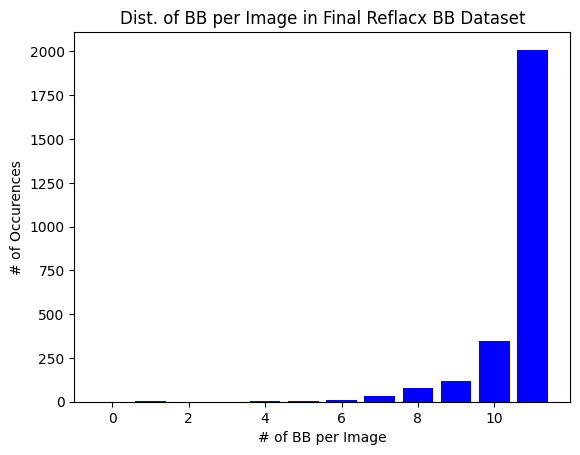

In [ ]:
finale = pd.DataFrame(pd.read_csv('/content/drive/MyDrive/ThesisWork/BB_CLASS/final_reflacx_detected_bb_v2F.csv'))

print(len(finale.dicom_id))
print(len(finale.dicom_id.unique()))
dicom_id = finale['dicom_id']

dic = dicom_id.value_counts().to_dict()
print(dic)

new_dic = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0}
for k,v in dic.items():
  new_dic[v] = new_dic[v] + 1
print(new_dic)

fig, ax = plt.subplots()

x = list(new_dic.keys())
y = list(new_dic.values())

ax.bar(x, y, color='blue')
ax.set_xlabel('# of BB per Image')
ax.set_ylabel('# of Occurences')
ax.set_title("Dist. of BB per Image in Final Reflacx BB Dataset")
plt.savefig('/content/drive/MyDrive/ThesisWork/BB_CLASS/final_reflac_bb_dist.png')
plt.show()

### GET DIST CSVs


In [ ]:
path = '/content/drive/MyDrive/XAMI-MIMIC/XAMI-MIMIC/'
metapath = '/content/drive/MyDrive/XAMI-MIMIC/XAMI-MIMIC/spreadsheets/REFLACX/metadata_updated.csv'

# silent_path = '/content/drive/MyDrive/ThesisWork/BB_CLASS/REFLACX_all_gazes_silent.csv'
report_path = '/content/drive/MyDrive/ThesisWork/BB_CLASS/REFLACX_all_gazes_report.csv'
filename = '/content/drive/MyDrive/ThesisWork/BB_CLASS/eleven_bb_reflacx.csv'

# silentdf = pd.DataFrame(pd.read_csv(silent_path))
reportdf = pd.DataFrame(pd.read_csv(report_path))
eleven = pd.DataFrame(pd.read_csv(filename))

In [ ]:
def gazes_dist3(df, final):

  df['zone'] = df.apply(lambda row: list(final.loc[final.dicom_id == row.dicom_id].loc[(final.x1 <= row.x_position) & (row.x_position <= final.x2) \
                                                                                 & (final.y1 <= row.y_position) & (row.y_position <= final.y2)].zone) , axis=1)
  return df


def gazes_dist2(res, df, final):

  for i in tqdm(final.dicom_id.unique()):

    for idx, row in df.loc[df.dicom_id == i].iterrows():
      zs = list(final.loc[final.dicom_id == i].loc[(final.x1 <= row.x_position) & (row.x_position <= final.x2) & (final.y1 <= row.y_position) & (row.y_position <= final.y2)].zone)
      # if len(zs) == 0:
      #   zs = ['nothing']
      res['count'] += res['zone'].apply(lambda x: x in zs).astype(int)

  return res

# def get_bb_from_point(df: pd.DataFrame, point: list) -> list:

#   zone = list([row.zone for idx, row in df.iterrows() if row.x1 <= point[0] <= row.x2 and row.y1 <= point[1] <= row.y2])
#   if len(zone) == 0:
#     zone.append('nothing')
#   return zone

# def gazes_dist(df, final):

#   result_dic = {'cardiac_silhouette':0, 'left_clavicle':0, 'left_costophrenic_angle':0,
#                         'left_hilar_structures':0, 'left_lung':0,
#                         'right_clavicle':0, 'right_costophrenic_angle':0,
#                         'right_hilar_structures':0, 'right_lung':0,
#                         'trachea':0, 'upper_mediastinum':0, 'nothing':0}

#   for idx, row in tqdm(df.iterrows()):

#     zones = get_bb_from_point(final.loc[final.dicom_id == row.dicom_id], [row.x_position, row.y_position])
#     for z in zones:
#       result_dic[z] = result_dic[z] + 1

#   return result_dic

def main():

  # load initial datasets
  # meta = pd.DataFrame(pd.read_csv(metapath))
  # meta = meta.loc[meta['eye_tracking_data_discarded'] == False]

  hsdf = silentdf.loc[silentdf.Total == 0]
  usdf = silentdf.loc[silentdf.Total != 0]
  hrdf = reportdf.loc[reportdf.Total == 0]
  urdf = reportdf.loc[reportdf.Total != 0]

  result_dic = {'cardiac_silhouette':0, 'left_clavicle':0, 'left_costophrenic_angle':0,
                     'left_hilar_structures':0, 'left_lung':0,
                        'right_clavicle':0, 'right_costophrenic_angle':0,
                        'right_hilar_structures':0, 'right_lung':0,
                        'trachea':0, 'upper_mediastinum':0, 'nothing':0}

  res = pd.DataFrame(result_dic.items(), columns=['zone', 'count'])

  cwd = "/content/drive/MyDrive/ThesisWork/BB_CLASS/"

  # hs = gazes_dist2(res, hsdf, eleven)
  # with open(cwd + 'healthy_silent_gaze_dist.csv', 'w') as f:
  #   hs.to_csv(f)
  # print("hs")

  # hr = gazes_dist2(res, hrdf, eleven)
  # with open(cwd + 'healthy_report_gaze_dist.csv', 'w') as f:
  #   hr.to_csv(f)
  # print("hr")

  # us = gazes_dist2(res, usdf, eleven)
  # with open(cwd + 'unhealthy_silent_gaze_dist.csv', 'w') as f:
  #   us.to_csv(f)
  # print("us")

  ur = gazes_dist2(res, urdf, eleven)
  with open(cwd + 'unhealthy_report_gaze_dist.csv', 'w') as f:
    ur.to_csv(f)
  print("ur")

print(main())

  0%|          | 0/2010 [00:00<?, ?it/s]

ur
None


In [ ]:
cwd = '/content/drive/MyDrive/ThesisWork/BB_CLASS/'
ghs = pd.DataFrame(pd.read_csv('/content/drive/MyDrive/ThesisWork/BB_CLASS/healthy_silent_gaze_dist.csv'))
ghr = pd.DataFrame(pd.read_csv('/content/drive/MyDrive/ThesisWork/BB_CLASS/healthy_report_gaze_dist.csv'))
gus = pd.DataFrame(pd.read_csv('/content/drive/MyDrive/ThesisWork/BB_CLASS/unhealthy_silent_gaze_dist.csv'))
gur = pd.DataFrame(pd.read_csv('/content/drive/MyDrive/ThesisWork/BB_CLASS/unhealthy_report_gaze_dist.csv'))

12358897
24294804


In [ ]:
def normalize_values(df: pd.DataFrame) -> list:
  num_gazes = df['count'].sum()
  return list([(row['count'] / num_gazes) for idx, row in df.iterrows()])

# # add normalized column
# ghs['Normalized'] = normalize_values(ghs)
# ghr['Normalized'] = normalize_values(ghr)
# gus['Normalized'] = normalize_values(gus)
# gur['Normalized'] = normalize_values(gur)


# save to csv
cwd = "/content/drive/MyDrive/ThesisWork/BB_CLASS/"

with open(cwd + 'healthy_silent_gaze_dist.csv', 'w') as f:
  ghs.to_csv(f)
with open(cwd + 'healthy_report_gaze_dist.csv', 'w') as f:
  ghr.to_csv(f)
with open(cwd + 'unhealthy_silent_gaze_dist.csv', 'w') as f:
  gus.to_csv(f)
with open(cwd + 'unhealthy_report_gaze_dist.csv', 'w') as f:
  gur.to_csv(f)


In [ ]:
from scipy.spatial.distance import jensenshannon as js

def js_divergence(df1:pd.DataFrame, df2:pd.DataFrame):
  # Jensen-Shannon divergence
  return js(list(df1['Normalized']), list(df2['Normalized']))

print("HS vs HR:", js_divergence(ghs, ghr))
print("HS vs US", js_divergence(ghs, gus))
print("US vs UR",js_divergence(gus, gur))
print("HR vs UR", js_divergence(ghr, gur))

HS vs HR: 0.0
HS vs US 0.048962094386774034
US vs UR 0.0
HR vs UR 0.048962094386774034


In [ ]:
# ADD bb to each gaze
from collections import Counter
# bb df RFX
cwd = "/content/drive/MyDrive/ThesisWork/BB_CLASS/"
eleven = pd.DataFrame(pd.read_csv(cwd + 'eleven_bb_reflacx.csv'))

def get_bb_gaze(x, y, dicom_id):

  bbs = [row.zone for idx, row in eleven.loc[eleven.dicom_id == dicom_id].iterrows() if row.x1 <= x <= row.x2 and row.y1 <= y <= row.y2]
  if len(bbs) == 0:
    bbs = ['nothing']
  return bbs

def get_gaze_count_df(df: pd.DataFrame):

  count = []
  for id in tqdm(df.dicom_id.unique()):

    xy_prev = [-1,-1]
    z, z_prev = [], []
    for idx, row in df.loc[df.dicom_id == id].iterrows():

      if [row.x_position, row.y_position] != xy_prev:
        xy_prev = [row.x_position, row.y_position]
        z = get_bb_gaze(row.x_position, row.y_position, id)
        z_prev = z
        count.extend(z)

      else:
        count.extend(z_prev)

  return count

def normalize_values(df: pd.DataFrame) -> list:
  num_gazes = df['num_gazes'].sum()
  return list([(row['num_gazes'] / num_gazes) for idx, row in df.iterrows()])

def main():

  # Load RFX metadata csv
  mddf = pd.read_csv('/content/drive/MyDrive/XAMI-MIMIC/XAMI-MIMIC/spreadsheets/REFLACX/metadata_updated.csv')
  mddf = mddf.loc[mddf['eye_tracking_data_discarded'] == False]

  # bb df RFX
  eleven = pd.DataFrame(pd.read_csv(cwd + 'eleven_bb_reflacx.csv'))

  # hs = get_gaze_count_df(silentdf[silentdf.Total == 0])
  # hsdf = pd.DataFrame(Counter(hs).items(), columns = ['zone', 'num_gazes'])
  # hsdf['normalized'] = normalize_values(hsdf)
  # with open(cwd + 'healthy_silent_gaze_dist.csv', 'w') as f:
  #   hsdf.to_csv(f)
  # print("DONE 1")

  # hr = get_gaze_count_df(reportdf[:18871768][reportdf.Total == 0])
  # hrdf = pd.DataFrame(Counter(hr).items(), columns = ['zone', 'num_gazes'])
  # hrdf['normalized'] = normalize_values(hrdf)
  # with open(cwd + 'healthy_report_gaze_dist_p1.csv', 'w') as f:
  #   hrdf.to_csv(f)
  # print("DONE 2")

  # us = get_gaze_count_df(silentdf[silentdf.Total != 0])
  # usdf = pd.DataFrame(Counter(us).items(), columns = ['zone', 'num_gazes'])
  # usdf['normalized'] = normalize_values(usdf)
  # with open(cwd + 'unhealthy_silent_gaze_dist.csv', 'w') as f:
  #   usdf.to_csv(f)
  # print("DONE 3")

  ur = get_gaze_count_df(reportdf[:18871768][reportdf.Total != 0])
  urdf = pd.DataFrame(Counter(ur).items(), columns = ['zone', 'num_gazes'])
  urdf['normalized'] = normalize_values(urdf)
  with open(cwd + 'unhealthy_report_gaze_dist_p1.csv', 'w') as f:
    urdf.to_csv(f)
  print("DONE 4")


main()



<ipython-input-10-9fbc86b8268f>:68: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ur = get_gaze_count_df(reportdf[:18871768][reportdf.Total != 0])


  0%|          | 0/225 [00:00<?, ?it/s]

### ADD BB TO EACH POINT


In [ ]:
elevendf = pd.DataFrame(pd.read_csv('/content/drive/MyDrive/ThesisWork/BB_CLASS/'))

def bbox_for_point(x, y, dicom_id):

  # if all bboxes are to be added
  bbs = [row.zone for idx, row in eleven.loc[eleven.dicom_id == dicom_id].iterrows() if row.x1 <= x <= row.x2 and row.y1 <= y <= row.y2]
  if len(bbs) == 0:
    bbs = ['nothing']
  return bbs

def main():

  meta = pd.read_csv('/content/drive/MyDrive/XAMI-MIMIC/XAMI-MIMIC/spreadsheets/REFLACX/metadata_updated.csv')
  meta = meta.loc[meta['eye_tracking_data_discarded'] == False]

  reportdf = pd.DataFrame(pd.read_csv('/content/drive/MyDrive/ThesisWork/BB_CLASS/REFLACX_all_gazes_report.csv'))

  reportdf['bbox_all'] = reportdf.apply(lambda row: bbox_for_point(row.x_position, row.y_position, row.dicom_id), axis=1)

  with open('/content/drive/MyDrive/ThesisWork/BB_CLASS/REFLACX_all_gazes_report_bb.csv', 'w') as f:
    reportdf.to_csv(f)

  print('DONE')

main()